In [1]:
# pip install pycaret

In [2]:
# pip install scikit-learn==1.1.0

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report 
from pycaret.classification import *


%matplotlib inline
pio.renderers.default='iframe'

pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)

# 1.0 Data retrieval

In [4]:
df = pd.read_pickle("../../data_lake/output/train.pkl")
val = pd.read_pickle("../../data_lake/output/val.pkl")

# 2.0 EDA

In [5]:
df = df.drop(columns=['dist2','customer_id','TransactionID'])
val = val.drop(columns=['dist2','customer_id','TransactionID'])

In [6]:
df = df.rename(columns={'id_31':'browser'})
val = val.rename(columns={'id_31':'browser'})

In [7]:
df['P_emaildomain'] = df['P_emaildomain'].mask(df['P_emaildomain']=='gmail','gmail.com')
val['P_emaildomain'] = val['P_emaildomain'].mask(val['P_emaildomain']=='gmail','gmail.com')

In [8]:
df['R_emaildomain'] = df['R_emaildomain'].mask(df['R_emaildomain']=='gmail','gmail.com')
val['R_emaildomain'] = val['R_emaildomain'].mask(val['R_emaildomain']=='gmail','gmail.com')

In [9]:
df['id_30'] = df['id_30'].replace(" ","_",regex=True)
df['id_30'] = df['id_30'].str.replace(".","_",regex=False)

In [10]:
val['id_30'] = val['id_30'].replace(" ","_",regex=True)
val['id_30'] = val['id_30'].str.replace(".","_",regex=False)

In [11]:
df['browser'] = df['browser'].mask(df['browser'].str.contains('SM') | df['browser'].str.contains('ZTE'),'other')
val['browser'] = val['browser'].mask(val['browser'].str.contains('SM') | val['browser'].str.contains('ZTE'),'other')

In [12]:
df['browser'] = df['browser'].astype(str)
val['browser'] = val['browser'].astype(str)

In [13]:
df['browser_enc'] = 'other'
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('ie'),'ie')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('safari'),'safari')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('edge'),'edge')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('firefox'),'firefox')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('Android'),'android')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('chrome'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('opera'),'opera')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('google'),'chrome')
df['browser_enc'] = df['browser_enc'].mask(df['browser'].str.contains('samsung'),'android')

In [14]:
val['browser_enc'] = 'other'
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('ie'),'ie')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('safari'),'safari')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('edge'),'edge')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('firefox'),'firefox')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('Android'),'android')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('chrome'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('opera'),'opera')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('google'),'chrome')
val['browser_enc'] = val['browser_enc'].mask(val['browser'].str.contains('samsung'),'android')

In [15]:
df['DeviceType'] = df['DeviceType'].mask(df['browser']== 'ie 11.0 for tablet','tablet')
val['DeviceType'] = val['DeviceType'].mask(val['browser']== 'ie 11.0 for tablet','tablet')

In [16]:
df = df.drop(columns='browser')
val = val.drop(columns='browser')

In [17]:
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info'] = df['DeviceInfo'].replace("-","_",regex=True)
df['device_info2'] = df['device_info'].replace(" ","_",regex=True)
df['device_info3'] = df['device_info2'].str.split("_").str[0]
df['device_info3'] = df['device_info3'].str.lower()

In [18]:
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info'] = val['DeviceInfo'].replace("-","_",regex=True)
val['device_info2'] = val['device_info'].replace(" ","_",regex=True)
val['device_info3'] = val['device_info2'].str.split("_").str[0]
val['device_info3'] = val['device_info3'].str.lower()

In [19]:
df['device_info_v4'] = 'other'
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='windows') | (df['device_info3']=='microsoft') | (df['device_info3']=='trident/7.0')),'windows')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='ios') | (df['device_info3']=='iphone')),'ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='blade','blade')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='lenovo','lenovo')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='redmi','redmi')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='pixel','pixel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='android','android')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='alcatel','alcatel')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='nokia','nokia')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='asus','asus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='oneplus','oneplus')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='zte','zte')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='macos','ios')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='hisense','hisense')
df['device_info_v4'] = df['device_info_v4'].mask(df['device_info3']=='linux','linux')
df['device_info_v4'] = df['device_info_v4'].mask((df['device_info3'].str.contains("lg") | (df['device_info3'].str.contains("nexus"))),'lg')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3'].str.contains("huawei")) | (df['device_info3'].str.contains("hi6210sft"))),'huawei')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='motog3') |(df['device_info3']=='moto')),'moto')
df['device_info_v4'] = df['device_info_v4'].mask(((df['device_info3']=='sm') |(df['device_info3']=='samsung')),'samsung')

In [20]:
val['device_info_v4'] = 'other'
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='windows') | (val['device_info3']=='microsoft') | (val['device_info3']=='trident/7.0')),'windows')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='ios') | (val['device_info3']=='iphone')),'ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='blade','blade')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='lenovo','lenovo')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='redmi','redmi')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='pixel','pixel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='android','android')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='alcatel','alcatel')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='nokia','nokia')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='asus','asus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='oneplus','oneplus')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='zte','zte')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='macos','ios')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='hisense','hisense')
val['device_info_v4'] = val['device_info_v4'].mask(val['device_info3']=='linux','linux')
val['device_info_v4'] = val['device_info_v4'].mask((val['device_info3'].str.contains("lg") | (val['device_info3'].str.contains("nexus"))),'lg')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3'].str.contains("huawei")) | (val['device_info3'].str.contains("hi6210sft"))),'huawei')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='motog3') |(val['device_info3']=='moto')),'moto')
val['device_info_v4'] = val['device_info_v4'].mask(((val['device_info3']=='sm') |(val['device_info3']=='samsung')),'samsung')

In [21]:
df = df.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])
val = val.drop(columns=['device_info','device_info2','device_info3','DeviceInfo'])

In [22]:
df.columns

Index(['isFraud', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3',
       'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain',
       'R_emaildomain', 'M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'max_c', 'max_d',
       'num_transactio_per_time', 'multi_transaction_per_time', 'browser_enc',
       'device_info_v4'],
      dtype='object')

In [23]:
cat = categorical_feautres = ['ProductCD', 'card1', 'card2', 'card3',
       'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain',
       'R_emaildomain', 'M4', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_32', 'id_33', 'id_34',
       'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType','browser_enc',
       'device_info_v4']

In [24]:
num = numerical_features=['TransactionAmt','max_c', 'max_d',
       'num_transactio_per_time', 'multi_transaction_per_time']

In [25]:
df.shape

(16054, 38)

In [26]:
df = df.sample(frac=0.5)

In [27]:
exp = setup(data = df, target = 'isFraud',fold_shuffle=True, session_id=2, categorical_features=cat, numeric_features=num,fix_imbalance = True,fold=2) 

,Description,Value
0,session_id,2
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8027, 38)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [28]:
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8295,0.9035,0.8261,0.8302,0.8282,0.6589,0.6590,1.4300
catboost,CatBoost Classifier,0.8286,0.9043,0.8165,0.8353,0.8258,0.6571,0.6573,8.5900
xgboost,Extreme Gradient Boosting,0.8247,0.9011,0.8211,0.8256,0.8233,0.6493,0.6493,14.9850
gbc,Gradient Boosting Classifier,0.8111,0.8886,0.8018,0.8155,0.8086,0.6222,0.6223,1154.0550
rf,Random Forest Classifier,0.8101,0.8881,0.7918,0.8202,0.8057,0.6201,0.6204,20.1850
ada,Ada Boost Classifier,0.7912,0.8651,0.7742,0.8000,0.7868,0.5823,0.5827,308.7350
et,Extra Trees Classifier,0.7844,0.8557,0.7553,0.8003,0.7771,0.5688,0.5697,3.9100
ridge,Ridge Classifier,0.7558,0.0000,0.7735,0.7456,0.7591,0.5116,0.5123,0.8050
lr,Logistic Regression,0.7554,0.8345,0.7610,0.7510,0.7559,0.5109,0.5110,11.3300
dt,Decision Tree Classifier,0.7512,0.7512,0.7560,0.7469,0.7514,0.5023,0.5024,14.2650


In [29]:
from imblearn.under_sampling import RandomUnderSampler

ru = RandomUnderSampler()

In [30]:
exp = setup(data = df, target = 'isFraud',fold_shuffle=True, session_id=2, categorical_features=cat, numeric_features=num,fix_imbalance = True,fold=2,fix_imbalance_method=ru) 

,Description,Value
0,session_id,2
1,Target,isFraud
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(8027, 38)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [31]:
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8302,0.9038,0.8243,0.8327,0.8285,0.6604,0.6604,1.8000
catboost,CatBoost Classifier,0.8257,0.9045,0.8111,0.8341,0.8224,0.6514,0.6517,7.1050
xgboost,Extreme Gradient Boosting,0.8254,0.9003,0.8211,0.8267,0.8239,0.6507,0.6508,12.1450
rf,Random Forest Classifier,0.8133,0.8897,0.7936,0.8245,0.8087,0.6265,0.6269,12.6900
gbc,Gradient Boosting Classifier,0.8113,0.8886,0.7993,0.8175,0.8083,0.6226,0.6227,854.4450
ada,Ada Boost Classifier,0.7900,0.8653,0.7796,0.7944,0.7869,0.5799,0.5800,191.8450
et,Extra Trees Classifier,0.7818,0.8565,0.7510,0.7984,0.7740,0.5634,0.5644,3.0050
lr,Logistic Regression,0.7615,0.8372,0.7678,0.7565,0.7621,0.5230,0.5231,8.5900
ridge,Ridge Classifier,0.7572,0.0000,0.7746,0.7470,0.7604,0.5145,0.5151,0.4200
dt,Decision Tree Classifier,0.7524,0.7524,0.7596,0.7471,0.7533,0.5048,0.5049,8.4950


In [20]:
# df = df.drop(columns=['ProductCD','card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
#                       'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38']) #'
# val = val.drop(columns=['ProductCD','card1', 'card2', 'card3','card5', 'card6','M4', 'id_21', 'id_22',
#                         'id_23','id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38'])# 

In [21]:
def model_training(X_train, y_train, numerical_cols, categorical_cols,parameters):
    """
    
    """
    
    ##
    numerical_preprocessor = Pipeline(steps=[("imputer", IterativeImputer(ExtraTreesRegressor(n_estimators=5,random_state=1,verbose=0),random_state=1,verbose=0,add_indicator=True)),
                                     ("scaler", MinMaxScaler())])
    categorical_preprocessor = Pipeline(steps=[("imputer", SimpleImputer(strategy='constant', fill_value='missing',verbose=0,add_indicator=True)),
                                           ("label_enc", OneHotEncoder(handle_unknown='ignore'))])
    preprocessor = ColumnTransformer(transformers=[("numerical_preprocessor", numerical_preprocessor, numerical_cols),
                                               ("categorical_preprocessor", categorical_preprocessor, categorical_cols)])
    pipe_model = GradientBoostingClassifier(random_state=0,n_iter_no_change=25,warm_start=True,max_features='auto')
    ##
    model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('model', pipe_model)])
    ##
    model_grid = GridSearchCV(model,parameters,cv=4,scoring='accuracy',verbose=0,return_train_score=True).fit(X_train,y_train)
    print('GridSearchCV results...')
    print("Mean Train Scores: \n{}\n".format(model_grid.cv_results_['mean_train_score']))
    print("Mean CV Scores: \n{}\n".format(model_grid.cv_results_['mean_test_score']))
    print("Best Parameters: \n{}\n".format(model_grid.best_params_))
    
    return model_grid

In [22]:
for i in df:
    if df[i].dtypes == 'object':
        df[i] = df[i].astype(str)

In [23]:
X_train = df.drop(columns='isFraud')
y_train = df['isFraud'].astype(float)

In [24]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [25]:
parameters = {'model__max_depth':[2,4],'model__n_estimators':[100,200,400],'model__learning_rate':[0.05,0.5,0.1]}

In [26]:
model = model_training(X_train,y_train,numerical_cols,categorical_cols,parameters)

GridSearchCV results...
Mean Train Scores: 
[0.78889994 0.80559358 0.82322158 0.83144383 0.84664249 0.85903821
 0.84942481 0.86794566 0.87130932 0.89626677 0.91032382 0.91165272
 0.80592585 0.82413517 0.84022677 0.8479506  0.86319092 0.8779743 ]

Mean CV Scores: 
[0.78447666 0.79892785 0.81144815 0.81954584 0.82901405 0.83586593
 0.82938773 0.83605299 0.83686286 0.8441506  0.84682911 0.84738965
 0.80011124 0.81325453 0.8240927  0.82920099 0.83717401 0.84153448]

Best Parameters: 
{'model__learning_rate': 0.5, 'model__max_depth': 4, 'model__n_estimators': 400}



In [27]:
def model_evaluation(model,X_test,y_test):
    """
    
    """
    print('Test results...')
    y_test_predict_grid = model.predict(X_test)    
    print("Model Test Accuracy:", metrics.accuracy_score(y_test, y_test_predict_grid))
    print('--------------------------------------------------')
    print('Model Test Confusion Matrix')
    cm = confusion_matrix(y_test,y_test_predict_grid,normalize='true') 
    cmd = ConfusionMatrixDisplay(cm,display_labels=['No','Yes'])
    cmd.plot()
    print('Classification report : \n',classification_report(y_test, y_test_predict_grid))

    ##
    feature_importances = model.best_estimator_.named_steps['model'].feature_importances_
    feature_names = X_test.columns
    lista = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
            print('{}: {}'.format(name, score))
            lista.append(name)
    # print('First ten features by importances:')
    # print(lista[0:15])
    
    return model

In [28]:
for i in val:
    if val[i].dtypes == 'object':
        val[i] = val[i].astype(str)

In [29]:
X_val = val.drop(columns='isFraud')
y_val = val['isFraud'].astype(float)

Test results...
Model Test Accuracy: 0.8498728911486018
--------------------------------------------------
Model Test Confusion Matrix
Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.85      0.91     19976
         1.0       0.32      0.84      0.46      1659

    accuracy                           0.85     21635
   macro avg       0.65      0.84      0.69     21635
weighted avg       0.93      0.85      0.88     21635

ProductCD: 0.35667826752470155
TransactionAmt: 0.06763904471191874
card1: 0.05669916549149737
card6: 0.022169908716670496
addr1: 0.006552035370932809
addr2: 0.005744400315802996
card5: 0.005586918211140751
max_d: 0.0004709873203631054
card2: 0.00037994461605065467
multi_transaction_per_time: 0.0002709677740402991
id_36: 0.00014420894528876052
card4: 0.00013346784528861616
id_22: 7.613746112136069e-05
card3: 1.4082215080602864e-05
num_transactio_per_time: 0.0
max_c: 0.0
id_38: 0.0
id_37: 0.0
id_35: 0.0
id_34

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_preprocessor',
                                                                         Pipeline(steps=[('imputer',
                                                                                          IterativeImputer(add_indicator=True,
                                                                                                           estimator=ExtraTreesRegressor(n_estimators=5,
                                                                                                                                         random_state=1),
                                                                                                           random_state=1)),
                                                                                         ('scaler',
                                                                  

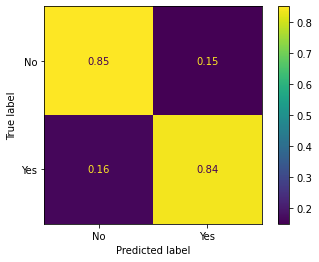

In [30]:
model_evaluation(model,X_val,y_val)

In [31]:
df['proba'] = model.predict_proba(df[X_train.columns])[:,1]
val['proba'] = model.predict_proba(val[X_train.columns])[:,1]

In [32]:
val.sample(3)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M4,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
84440,0,100.0,R,15063,514.0,150.0,visa,226.0,credit,472.0,87.0,gmail.com,aol.com,nan,nan,nan,nan,nan,nan,nan,nan,New,NotFound,iOS_10_3_3,32.0,2048x1536,match_status:1,T,F,F,F,mobile,1.0,0.000,1,0,safari,ios,0.034391
78776,0,125.0,R,1724,583.0,150.0,visa,226.0,credit,126.0,87.0,yahoo.com,aol.com,nan,nan,nan,nan,nan,nan,nan,nan,Found,Found,Windows_7,24.0,1366x768,match_status:2,T,F,F,T,desktop,1.0,917.875,1,0,ie,other,0.004486
88029,0,200.0,R,6019,583.0,150.0,visa,226.0,credit,299.0,87.0,aol.com,gmail.com,nan,nan,nan,nan,nan,nan,nan,nan,New,NotFound,iOS_9_3_5,32.0,2048x1536,match_status:1,T,F,F,T,mobile,2.0,733.000,1,0,safari,ios,0.595580


In [33]:
df.sample(3)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M4,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
79093,1,200.000,H,14182,562.0,150.0,mastercard,102.0,credit,231.0,87.0,yahoo.com,yahoo.com,nan,252.0,14.0,IP_PROXY:TRANSPARENT,11.0,321.0,184.0,Found,Found,Found,Android_7_0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,6.0,19.625,1,0,android,samsung,0.985347
3814,0,200.000,R,8104,399.0,150.0,american express,118.0,credit,204.0,87.0,yahoo.com,yahoo.com,nan,nan,nan,nan,nan,nan,nan,nan,New,NotFound,Mac_OS_X_10_13_1,24.0,1440x900,match_status:2,T,F,F,F,desktop,1.0,0.000,1,0,safari,ios,0.031350
84251,1,17.643,C,2256,545.0,185.0,visa,226.0,credit,nan,nan,hotmail.com,hotmail.com,M2,nan,nan,nan,nan,nan,nan,nan,Found,Found,nan,nan,nan,nan,F,F,T,F,mobile,97.0,155.000,1,0,android,samsung,0.927547


In [34]:
val['isFraud'].value_counts()

0    19976
1     1659
Name: isFraud, dtype: int64

In [35]:
val[val['isFraud']=='1'].sample(3)

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M4,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,max_c,max_d,num_transactio_per_time,multi_transaction_per_time,browser_enc,device_info_v4,proba
5209,1,56.311,C,3867,296.0,185.0,visa,226.0,credit,161.0,60.0,gmail.com,gmail.com,M2,nan,nan,nan,nan,nan,nan,nan,Found,Found,nan,nan,nan,nan,F,F,T,T,desktop,4.0,2.0,1,0,chrome,other,0.907497
69345,1,74.041,C,4504,500.0,185.0,mastercard,219.0,credit,nan,nan,hotmail.com,hotmail.com,M0,nan,nan,nan,nan,nan,nan,nan,New,NotFound,nan,nan,nan,nan,F,F,T,F,desktop,8.0,255.0,1,0,chrome,windows,0.620486
131178,1,6.517,C,9633,130.0,185.0,visa,138.0,debit,nan,nan,hotmail.com,hotmail.com,M2,nan,nan,nan,nan,nan,nan,nan,New,NotFound,nan,nan,nan,nan,F,F,T,F,mobile,44.0,38.0,1,0,chrome,samsung,0.688626
